In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from collections import Counter, defaultdict
from scipy.stats import lognorm

In [2]:
file_path = "./data/processed_myData.csv"

df = pd.read_csv(file_path, index_col=0)
df = df.reset_index(drop=True)

/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.head()

,dolocationid,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pulocationid,ratecodeid,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid,duration
0,1,0.0,2.5,0.3,0.5,3,2,1,1,0.00,0.00,3.30,2019-01-01 10:10:33,2019-01-01 10:10:30,16.9,1,0 days 00:00:03.000000000
1,1,0.0,0.0,0.3,0.0,3,3,1,5,0.00,16.26,16.56,2019-01-01 10:11:32,2019-01-01 10:10:52,16.9,1,0 days 00:00:40.000000000
2,1,0.0,0.0,0.3,0.0,3,3,1,5,0.00,16.26,16.56,2019-01-01 10:13:13,2019-01-01 10:12:05,16.9,1,0 days 00:01:08.000000000
3,1,0.0,120.0,0.3,0.0,3,2,1,5,0.00,16.26,136.56,2019-01-01 10:14:35,2019-01-01 10:13:44,16.9,1,0 days 00:00:51.000000000
4,1,0.0,135.0,0.3,0.0,4,1,1,5,33.05,30.00,198.35,2019-01-01 12:49:31,2019-01-01 12:49:12,19.3,1,0 days 00:00:19.000000000


## Trip Duration

In [4]:
trip_dur_secs = pd.to_timedelta(df['duration']).dt.total_seconds()
trip_dur_secs.head(10)

0        3.0
1       40.0
2       68.0
3       51.0
4       19.0
5     3173.0
6    83072.0
7      166.0
8        5.0
9       87.0
Name: duration, dtype: float64

Counter({'short_trip': 1252660, 'medium_trip': 522068, 'long_trip': 48089})


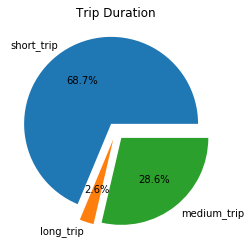

In [5]:
trip_dur_mins = trip_dur_secs / 60
count_mins = Counter()

"""
short_trip: duration less than 20 minutes
medium_trip: duration greater than or equal to 20 mins but less than 40 mins
long trip: duration greater than or equal to 40 mins but less than 90mins
others: duration longer than or equal ot 90mins
"""
for dur_mins in trip_dur_mins:
    if dur_mins < 15:
        count_mins['short_trip'] += 1
    elif dur_mins < 40:
        count_mins['medium_trip'] += 1
    else:
        count_mins['long_trip'] += 1

print(count_mins)
key_value_pairs = count_mins.items()

fig, ax = plt.subplots()
ax.pie([x[-1] for x in key_value_pairs], labels=[x[0] for x in key_value_pairs], explode=(0.1, 0.1, 0.1), autopct='%1.1f%%')
ax.set_title('Trip Duration')
plt.show()

## Passenger Count

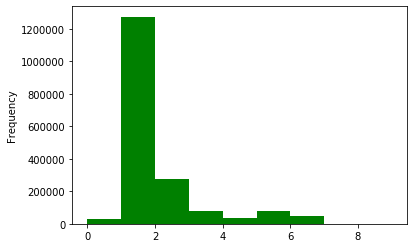

In [6]:
passenger_count = df['passenger_count']
passenger_count.plot.hist(bins=np.arange(10), color='g')

In [7]:
passenger_count.head()

0    3
1    3
2    3
3    3
4    4
Name: passenger_count, dtype: int64

dict_items([(3, 78928), (4, 36689), (1, 1274605), (2, 275127), (5, 79486), (6, 49961)])


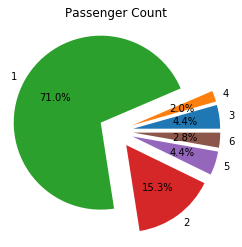

In [8]:
# find some rows with 0 or more than 6 passengers, should get rid of them
passenger_counter = Counter()
for cnt in passenger_count:
    if cnt == 0 or cnt >= 7:
        continue
    passenger_counter[cnt] += 1

count_items = passenger_counter.items()
print(count_items)

fig, ax = plt.subplots()
ax.pie([x[-1] for x in count_items], labels=[x[0] for x in count_items], explode=[0.2] * len(count_items), autopct='%1.1f%%')
ax.set_title('Passenger Count')
plt.show()

## Trip Distance

In [9]:
trip_dist = df['trip_distance']
trip_dist.head(10)

0    16.90
1    16.90
2    16.90
3    16.90
4    19.30
5    41.28
6     0.11
7     1.27
8    12.65
9    17.70
Name: trip_distance, dtype: float64

In [10]:
trip_dist.describe()

count    1.822817e+06
mean     2.712756e+00
std      3.201634e+00
min      1.000000e-02
25%      9.900000e-01
50%      1.620000e+00
75%      3.100000e+00
max      1.386400e+02
Name: trip_distance, dtype: float64

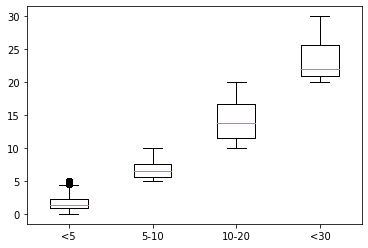

In [11]:
trip_dist_counter = defaultdict(list)

for d in trip_dist:
    # only consider trip distance less than 30 miles
    if d < 5:
        trip_dist_counter['<5'].append(d)
    elif d < 10:
        trip_dist_counter['5-10'].append(d)
    elif d < 20:
        trip_dist_counter['10-20'].append(d)
    elif d <= 30:
        trip_dist_counter['<30'].append(d)

dist_items = sorted(trip_dist_counter.items(), key=lambda x:x[-1])
plt.boxplot([x[-1] for x in dist_items], labels=[x[0] for x in dist_items])
plt.show()

{'10-20': 61861, '<5': 1587594, '5-10': 166061, '<30': 6687}


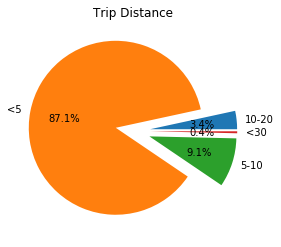

In [12]:
trip_dist_counter2 = {}
for k in trip_dist_counter:
    trip_dist_counter2[k] = len(trip_dist_counter[k])

print(trip_dist_counter2)
    
count_items = trip_dist_counter2.items()
fig, ax = plt.subplots()
ax.pie([x[-1] for x in count_items], labels=[x[0] for x in count_items], explode=[0.2] * len(count_items), autopct='%1.1f%%')
ax.set_title('Trip Distance')
plt.show()

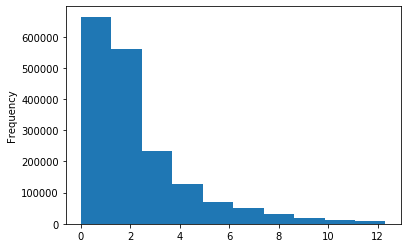

In [13]:
trip_dist_mean = trip_dist.mean()
trip_dist_std = trip_dist.std()

# remove outliers based on 3-sigma rule
trip_dist = trip_dist[(trip_dist - trip_dist_mean).abs() < 3 * trip_dist_std]
trip_dist.plot.hist()  # should focus on trips with distance less than 8 miles

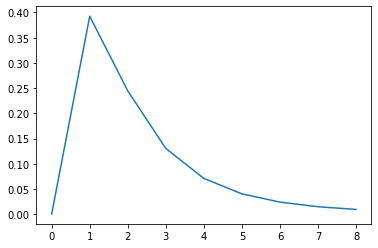

In [14]:
# log-normal fit
shape, location, scale = lognorm.fit(trip_dist, scale=trip_dist_mean, loc=0)
normed = lognorm.pdf(np.arange(9), shape, location, scale)
plt.plot(np.arange(9), normed)
plt.show()

## Rate Code
RateCodeID: The final rate code in effect at the end of the trip.(1= Standard rate 2=JFK 3=Newark 4=Nassau or Westchester 5=Negotiated fare 6=Group ride)

In [15]:
rate_code = df['ratecodeid']
rate_code_counter = Counter(rate_code)
print(rate_code_counter)

Counter({1: 1780593, 5: 19004, 2: 18885, 3: 3922, 4: 387, 99: 22, 6: 4})


In [16]:
code_map = {
    1: 'Standard',
    2: 'JFK',
    3: 'Newark',
    4: 'Nassau or Westchester',
    5: 'Negotiated Fare',
    6: 'Group Ride',
    99: 'others'
}

total = sum(rate_code_counter.values())
for k, v in rate_code_counter.items():
    percentile = 100 * v / total
    print("{}% trips are {}".format(round(percentile, 3), code_map[k]))

97.684% trips are Standard
1.043% trips are Negotiated Fare
1.036% trips are JFK
0.215% trips are Newark
0.021% trips are Nassau or Westchester
0.001% trips are others
0.0% trips are Group Ride


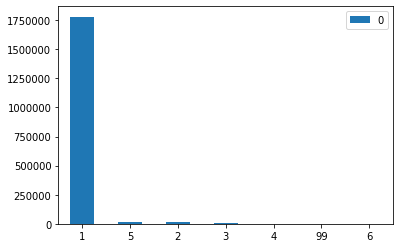

In [17]:
df_rate_code = pd.DataFrame(rate_code_counter.values(), index=rate_code_counter.keys())
ax = df_rate_code.plot.bar(rot=0)